In [ ]:
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, fbeta_score, classification_report, matthews_corrcoef
from sklearn.metrics import make_scorer 
import matplotlib.pyplot as plt
import gensim.downloader as api

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
dir_name = "/content/gdrive/MyDrive/Thesis/"

Mounted at /content/gdrive


In [ ]:
def get_raw_data(dir_name, file_name):
    #  load data
    data = pd.read_csv('{}{}.csv'.format(dir_name,file_name), encoding = 'latin-1', usecols=['Message_body', 'Label'])
    data = data.rename(columns={'Label': 'label', 'Message_body': 'text'})
    le = LabelEncoder()
    data['label'] = le.fit_transform( data['label'])
    return data

In [ ]:
raw_train_data = get_raw_data(dir_name + 'datasets/email_spam/', 'train')

In [ ]:
raw_train_data

,text,label
0,Rofl. Its true to its name,0
1,The guy did some bitching but I acted like i'd...,0
2,"Pity, * was in mood for that. So...any other s...",0
3,Will ü b going to esplanade fr home?,0
4,This is the 2nd time we have tried 2 contact u...,1
...,...,...
952,hows my favourite person today? r u workin har...,0
953,How much you got for cleaning,0
954,Sorry da. I gone mad so many pending works wha...,0
955,Wat time ü finish?,0


In [ ]:
raw_train_data['text'].is_unique

False

In [ ]:
raw_train_data.drop_duplicates(subset=['text'], inplace=True)

In [ ]:
raw_train_data['text'].is_unique

True

In [ ]:
raw_train_data

,text,label
0,Rofl. Its true to its name,0
1,The guy did some bitching but I acted like i'd...,0
2,"Pity, * was in mood for that. So...any other s...",0
3,Will ü b going to esplanade fr home?,0
4,This is the 2nd time we have tried 2 contact u...,1
...,...,...
952,hows my favourite person today? r u workin har...,0
953,How much you got for cleaning,0
954,Sorry da. I gone mad so many pending works wha...,0
955,Wat time ü finish?,0


In [ ]:
def get_dataset_statistics(data):
    dataset_statistics = {'Number of emails': [data['label'].value_counts()[0], data['label'].value_counts()[1]]}
    df = pd.DataFrame(dataset_statistics, index=['Non-Spam', 'Spam'])
    df.plot(kind='pie', y='Number of emails', figsize=(6, 6), fontsize=14,
            autopct=lambda v: '{:.0f} ({:.1f}%)'.format(v / 100 * data['label'].count(), v))

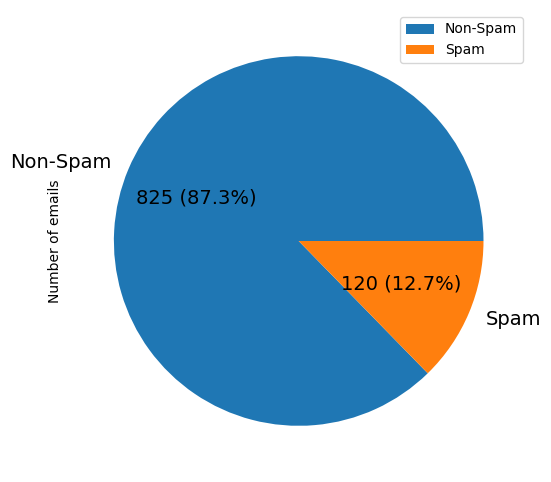

In [ ]:
# Raw data statistics
get_dataset_statistics(raw_train_data)

In [ ]:
raw_test_data = get_raw_data(dir_name + 'datasets/email_spam/', 'test')

In [ ]:
raw_test_data

,text,label
0,"UpgrdCentre Orange customer, you may now claim...",1
1,"Loan for any purpose £500 - £75,000. Homeowner...",1
2,Congrats! Nokia 3650 video camera phone is you...,1
3,URGENT! Your Mobile number has been awarded wi...,1
4,Someone has contacted our dating service and e...,1
...,...,...
120,7 wonders in My WORLD 7th You 6th Ur style 5th...,0
121,Try to do something dear. You read something f...,0
122,Sun ah... Thk mayb can if dun have anythin on....,0
123,"SYMPTOMS when U are in love: ""1.U like listeni...",0


In [ ]:
raw_test_data['label'].value_counts()

1    76
0    49
Name: label, dtype: int64

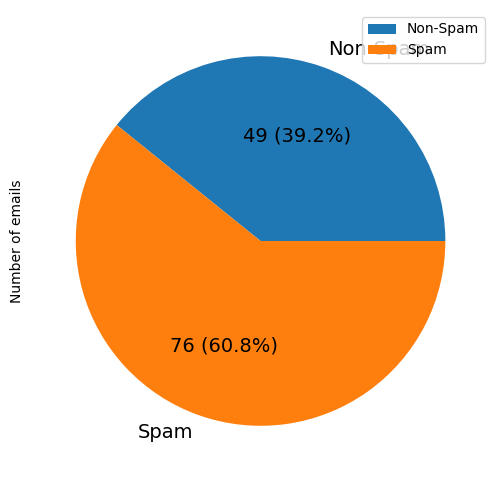

In [ ]:
get_dataset_statistics(raw_test_data)

# Text Preprocessing 

In [ ]:
import requests
stopwords_list = requests.get("https://github.com/stopwords-iso/stopwords-en/blob/master/stopwords-en.txt").content
stopwords = set(stopwords_list.decode().splitlines())

In [ ]:
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
sklearn_stopwords = ENGLISH_STOP_WORDS

stop_words = set(stopwords.words('english'))
stop_words.update(sklearn_stopwords)

def message_preprocessing(raw_message):
  message_words = raw_message.translate(str.maketrans('', '', string.punctuation))
  msg_tokens = word_tokenize(message_words.lower())
  filtered_message = [token for token in msg_tokens if not token in stop_words]
  return " ".join(filtered_message)

In [ ]:
train_data = raw_train_data[['text', 'label']].copy()

train_data['text'] = raw_train_data['text'].apply(message_preprocessing)

train_data.drop_duplicates(inplace=True)

train_data

,text,label
0,rofl true,0
1,guy bitching acted like id interested buying w...,0
2,pity mood soany suggestions,0
3,ü b going esplanade fr home,0
4,2nd time tried 2 contact u u £750 pound prize ...,1
...,...,...
952,hows favourite person today r u workin hard sl...,0
953,got cleaning,0
954,sorry da gone mad pending works,0
955,wat time ü finish,0


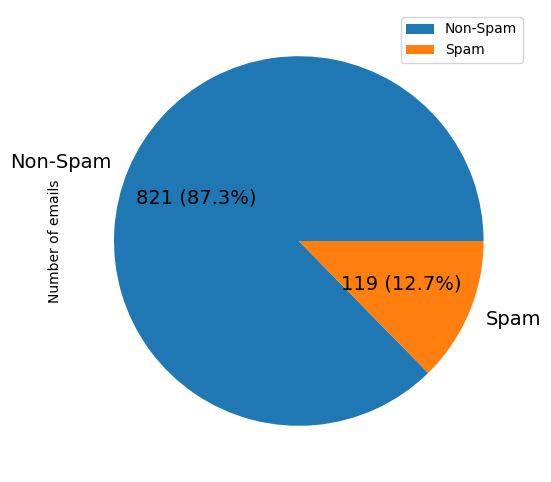

In [ ]:
get_dataset_statistics(train_data)

In [ ]:
test_data = raw_test_data[['text', 'label']].copy()

test_data['text'] = raw_test_data['text'].apply(message_preprocessing)

test_data.drop_duplicates(inplace=True)

test_data

,text,label
0,upgrdcentre orange customer claim free camera ...,1
1,loan purpose £500 £75000 homeowners tenants we...,1
2,congrats nokia 3650 video camera phone 0906638...,1
3,urgent mobile number awarded £2000 prize guara...,1
4,contacted dating service entered phone fancy l...,1
...,...,...
120,7 wonders world 7th 6th ur style 5th ur smile ...,0
121,try dear read exams,0
122,sun ah thk mayb dun anythin thk book e lesson ...,0
123,symptoms u love 1u like listening songs 2u sto...,0


In [ ]:
word2vec_model = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
def get_text_vec(sent):
  vector = np.mean(np.array([word2vec_model[token] for token in word_tokenize(sent) if token in word2vec_model.key_to_index]), axis=0)
  if np.all(np.isnan(vector)) :
    return np.zeros(300)
  return vector

In [ ]:
X_test = np.stack(np.array([get_text_vec(sms_text) for sms_text in test_data['text'].values]))

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
X_test.shape

(124, 300)

In [ ]:
y_test = test_data['label'].values

In [ ]:
y_test.shape

(124,)

# Model selection, training and evaluation

In [ ]:
def f_beta_score(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2, average='binary')

f2_score = make_scorer(f_beta_score, greater_is_better=True)

In [ ]:
from datetime import datetime

def save_cross_validation(results, file_name):
  results_to_save = pd.DataFrame(columns=['Accuracy', 'Recall', 'Precision', 'F1 Score', 'F2 Score', 'MCC'])
  for i in range(0, 10):
    results_to_save.loc[i] = [
      results['split{}_test_Accuracy'.format(i)][0],
      results['split{}_test_Recall'.format(i)][0],
      results['split{}_test_Precision'.format(i)][0],
      results['split{}_test_F1'.format(i)][0],
      results['split{}_test_F2'.format(i)][0],
      results['split{}_test_MCC'.format(i)][0]
    ]
  results_to_save.to_csv('{}Results/{}_{}.csv'.format(dir_name+'experiments/Email Spam/', file_name, datetime.now().strftime("%m%d%H%M")))

In [ ]:
def train_model(classifier, param_grid, model_name, train_texts, train_labels, test_texts, test_labels, evaluation_metrics, to_print=True, to_save=False, file_name=None):
    """
    train email classification model.
    """

    # apply grid search to find best model hyper parameters
    grid_search = GridSearchCV(classifier, param_grid, cv=10, scoring={'Accuracy': make_scorer(accuracy_score),
                                                                       'F1': make_scorer(f1_score),
                                                                       'F2': f2_score,
                                                                       'Recall': make_scorer(recall_score),
                                                                       'Precision': make_scorer(precision_score),
                                                                       'MCC' : make_scorer(matthews_corrcoef)
                                                                       }, refit='F1', n_jobs=-1)
    grid_search.fit(train_texts, train_labels)
    model = grid_search.best_estimator_

    if to_save:
      ConfusionMatrixDisplay(save_cross_validation(grid_search.cv_results_, file_name))
      plt.show()

    # train and test accuracy.
    test_accuracy = model.score(test_texts, test_labels)
    train_accuracy = model.score(train_texts, train_labels)

    # compute F1 score for model evaluation.
    y_pred = model.predict(test_texts)

    recall = recall_score(test_labels, y_pred)
    precision = precision_score(test_labels, y_pred)
    f1score = f1_score(test_labels, y_pred)
    f2score = fbeta_score(y_test, y_pred, beta=2, average='binary')
    mcc = matthews_corrcoef(y_test, y_pred)

    if to_print:
        print("train accuracy = " + str(train_accuracy))
        print("test accuracy = " + str(test_accuracy))
        print("Recall = {}".format(recall))
        print("Precision = {}".format(precision))
        print("F1 score = {}".format(f1score))
        print("F2 score = {}".format(f2score))
        print("MCC = {}".format(mcc))
        print(classification_report(test_labels, y_pred))


        # plot confusion matrix
        cm = confusion_matrix(test_labels, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])

        disp.plot(cmap=plt.cm.Blues)
        plt.show()

        # print best model hyper parameters.
        print(grid_search.best_params_)

    evaluation_metrics.loc[model_name, 'Recall'] = recall
    evaluation_metrics.loc[model_name, 'Precision'] = precision
    evaluation_metrics.loc[model_name, 'F1 score'] = f1score
    evaluation_metrics.loc[model_name, 'F2 score'] = f2score
    evaluation_metrics.loc[model_name, 'MCC'] = mcc

    return f1score, f2score


def train(model_id, train_texts, train_labels, test_texts, test_labels, evaluation_metrics, to_print=True, to_save=False, file_name=None):
    
    if model_id == 1:
        # Random forest Classification model.
        forest_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
        forest_param_grid = [{'n_estimators': [5,10,15,20,25], 'max_features': [10, 15, 20], 'min_samples_split': [15, 20, 25], 'criterion': ['gini','entropy'], 'max_depth': [5,6,7]}]

        return train_model(forest_clf, forest_param_grid, 'RandomForest', train_texts, train_labels, test_texts, test_labels, evaluation_metrics, to_print, to_save, file_name)

    if model_id == 2:
        # Support Vector Machine Model.
        svc_clf = SVC(random_state=42)
        svc_param_grid = [{'kernel': ['rbf'], 'degree': [2, 3 ,4, 5]}]

        return train_model(svc_clf, svc_param_grid, 'SVM', train_texts, train_labels, test_texts, test_labels, evaluation_metrics, to_print, to_save, file_name)

# Text Augmentation

In [ ]:
import gensim
import random 

class Word2vec:
    """
    A set of functions used to augment data.
    Typical usage: :: 
        >>> from textaugment import Word2vec
        >>> t = Word2vec('path/to/gensim/model'or 'gensim model itself')
        >>> t.augment('I love school')
        i adore school
    """
    
    def __init__(self, **kwargs):
        """
        A method to initialize a model on a given path.
        :type random_state: int, float, str, bytes, bytearray
        :param random_state: seed
        :type model: str or gensim.models.word2vec.Word2Vec
        :param model: The path to the model or the model itself.
        :type runs: int, optional
        :param runs: The number of times to augment a sentence. By default is 1.
        :type v: bool or optional
        :param v: Replace all the words if true. If false randomly replace words.
                Used in a Paper (https://www.cs.cmu.edu/~diyiy/docs/emnlp_wang_2015.pdf)
        :type p: float, optional
        :param p: The probability of success of an individual trial. (0.1<p<1.0), default is 0.5
        """

        # Set random state
        if 'random_state' in kwargs:
            self.random_state = kwargs['random_state']
            if isinstance(self.random_state, int):
                random.seed(self.random_state)
                np.random.seed(self.random_state)
            else:
                raise TypeError("random_state must have type int")

        # Set verbose to false if does not exists
        try:
            if kwargs['v']: 
                self.v = True
            else:
                self.v = False
        except KeyError:
            self.v = False

        try:
            if "p" in kwargs:
                if type(kwargs['p']) is not float:
                    raise TypeError("p represent probability of success and must be a float from 0.1 to 0.9. E.g p=0.5")
                elif type(kwargs['p']) is float:
                    self.p = kwargs['p']
            else:
                kwargs['p'] = 0.5  # Set default value
        except KeyError:
            raise

        # Error handling of given parameters
        try:
            if "runs" not in kwargs:
                kwargs["runs"] = 1  # Default value for runs
            elif type(kwargs["runs"]) is not int:
                raise TypeError("DataType for 'runs' must be an integer")
            if "model" not in kwargs:
                raise ValueError("Set the value of model. e.g model='path/to/model' or model itself")
            if type(kwargs['model']) not in [str,
                                             gensim.models.word2vec.Word2Vec,
                                             gensim.models.keyedvectors.Word2VecKeyedVectors,
                                            gensim.models.keyedvectors.FastTextKeyedVectors]:
                raise TypeError("Model path must be a string. "
                                "Or type of model must be a gensim.models.word2vec.Word2Vec or "
                                "gensim.models.keyedvectors.Word2VecKeyedVectors or "
                                "gensim.models.keyedvectors.FastTextKeyedVectors type. "
                                "To load a model use gensim.models.Word2Vec.load('path')")
        except (ValueError, TypeError):
            raise
        else:
            self.runs = kwargs["runs"] 
            self.model = kwargs["model"]
            self.p = kwargs["p"]
            try:
                if type(self.model) is str:
                    self.model = gensim.models.Word2Vec.load(self.model)
            except FileNotFoundError:
                print("Error: Model not found. Verify the path.\n")
                raise

    def geometric(self, data):
        """
        Used to generate Geometric distribution.
        :type data: list
        :param data: Input data
        :rtype:   ndarray or scalar
        :return:  Drawn samples from the parameterized Geometric distribution.
        """

        data = np.array(data)
        first_trial = np.random.geometric(p=self.p, size=data.shape[0]) == 1  # Capture success after first trial
        return data[first_trial]

    def augment(self, data):
        """
        The method to replace words with similar words.
        
        :type data: str
        :param data: Input data
        :rtype:   str
        :return:  The augmented data
        """
        
        # Avoid nulls and other unsupported types
        if type(data) is not str: 
            raise TypeError("Only strings are supported")
        # Lower case and split
        data_tokens = data.lower().split()

        # Verbose = True then replace all the words.
        if self.v:
            for _ in range(self.runs):
                for index in range(len(data_tokens)):  # Index from 0 to length of data_tokens
                    try:
                        similar_words = [syn for syn, t in self.model.most_similar(data_tokens[index])]
                        r = random.randrange(len(similar_words))
                        data_tokens[index] = similar_words[r].lower()  # Replace with random synonym from 10 synonyms
                    except KeyError:
                        pass  # For words not in the word2vec model
        else:  # Randomly replace some words
            for _ in range(self.runs):
                data_tokens_idx = [[x, y] for (x, y) in enumerate(data_tokens)]  # Enumerate data
                words = self.geometric(data=data_tokens_idx).tolist()  # List of words indexed
                for w in words:
                    try:
                        similar_words_and_weights = [(syn, t) for syn, t in self.model.most_similar(w[1])]
                        similar_words = [word for word, t in similar_words_and_weights]
                        similar_words_weights = [t for word, t in similar_words_and_weights]
                        word = random.choices(similar_words, similar_words_weights, k=1)
                        data_tokens[int(w[0])] = word[0].lower()  # Replace with random synonym from 10 synonyms
                    except KeyError:
                        pass
            return " ".join(data_tokens)
        return " ".join(data_tokens)

In [ ]:
marivate_augmener = Word2vec(model=word2vec_model, runs=1, v=False, p=0.5)

In [ ]:
def marivate_augmentation(prepro_dataset, lable, sent_num=5):
  texts = prepro_dataset.loc[prepro_dataset['label'] == lable]['text'].values
  texts_num = len(texts)
  new_texts = []
  i = 0
  
  for text in texts:
    if i % 20 == 0:
      print(f" {int(100*i/texts_num)} %")
    for j in range(sent_num):
      new_texts.append(marivate_augmener.augment(text))
    i += 1
  augmentations = prepro_dataset[['text', 'label']].copy().append(pd.DataFrame({'label':[lable] * len(new_texts), 'text':new_texts}), ignore_index = True)
  augmentations.drop_duplicates(inplace=True)
  return augmentations.sample(frac=1)

In [ ]:
augmented_dataset =  marivate_augmentation(train_data, lable=1, sent_num=5)

 0 %
 16 %
 33 %
 50 %
 67 %
 84 %


<ipython-input-26-27a6d5a3b793>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmentations = prepro_dataset[['text', 'label']].copy().append(pd.DataFrame({'label':[lable] * len(new_texts), 'text':new_texts}), ignore_index = True)


In [ ]:
augmented_dataset

,text,label
399,ok leave need ask,0
1124,selected receiving £350 lifetime_achievement_a...,1
1381,lyricalladie21f inviting friend curt_reply yes...,1
265,make tonight,0
1096,urgent 1 morning free membership_dues £100000 ...,1
...,...,...
112,sparkling shopping breaks 45 person 0121 20250...,1
1196,9 revamped congratulatory_message 08715205273,1
119,latest news police station toilet stolen cops,1
1342,5th day attempted 1 gene.wojciechowski_@_espn3...,1


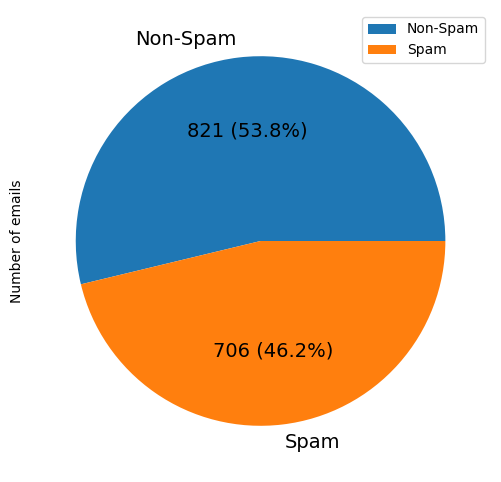

In [ ]:
get_dataset_statistics(augmented_dataset)

In [ ]:
aug_X_train = np.stack(np.array([get_text_vec(sms_text) for sms_text in augmented_dataset['text'].values]))

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
aug_X_train.shape

(1529, 300)

In [ ]:
aug_y_train = augmented_dataset['label'].values

In [ ]:
aug_y_train.shape

(1529,)

## Random forest

In [ ]:
evaluation_metrics_aug = pd.DataFrame(columns = ['Recall', 'Precision', 'F1 score', 'F2 score', 'MCC'])

train accuracy = 0.9810333551340745
test accuracy = 0.8870967741935484
Recall = 0.8666666666666667
Precision = 0.9420289855072463
F1 score = 0.9027777777777778
F2 score = 0.8807588075880759
MCC = 0.7725227106087207
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        49
           1       0.94      0.87      0.90        75

    accuracy                           0.89       124
   macro avg       0.88      0.89      0.88       124
weighted avg       0.89      0.89      0.89       124



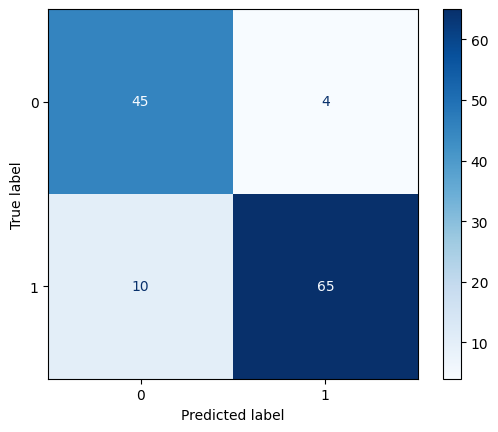

{'criterion': 'entropy', 'max_depth': 6, 'max_features': 20, 'min_samples_split': 25, 'n_estimators': 20}


(0.9027777777777778, 0.8807588075880759)

In [ ]:
train(1, aug_X_train, aug_y_train, X_test, y_test, evaluation_metrics_aug, to_save=True, file_name='Mari_RF')

# SVM

train accuracy = 0.9947678221059516
test accuracy = 0.9112903225806451
Recall = 0.8666666666666667
Precision = 0.9848484848484849
F1 score = 0.9219858156028369
F2 score = 0.8879781420765026
MCC = 0.8291741471774795
              precision    recall  f1-score   support

           0       0.83      0.98      0.90        49
           1       0.98      0.87      0.92        75

    accuracy                           0.91       124
   macro avg       0.91      0.92      0.91       124
weighted avg       0.92      0.91      0.91       124



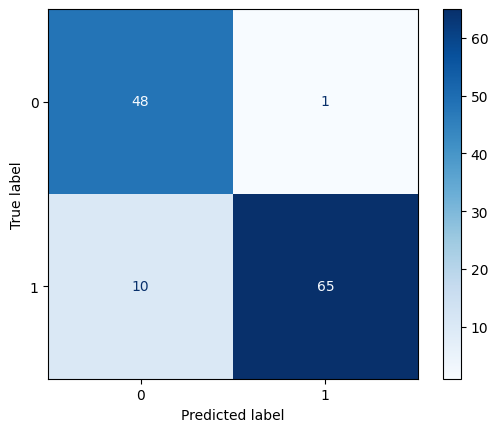

{'degree': 2, 'kernel': 'rbf'}


(0.9219858156028369, 0.8879781420765026)

In [ ]:
train(2, aug_X_train, aug_y_train, X_test, y_test, evaluation_metrics_aug, to_save=True, file_name='Mari_SVM')

#BiLSTM

In [ ]:
import random
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
seed = 221
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
text_words_lengths = [len(raw_train_data.loc[i]['text'].split()) for i in raw_train_data.index ]
total_length = np.sum(text_words_lengths)
text_words_mean = int(np.mean(text_words_lengths))

In [ ]:
def create_blstm_model(sent_length, words_mean, train_texts):

  text_vec = layers.TextVectorization( 
    max_tokens=sent_length,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=words_mean
  )

  text_vec.adapt(train_texts)

  embedding_layer = layers.Embedding(
    input_dim=sent_length,
    output_dim=128,
    embeddings_initializer='uniform',
    input_length=words_mean
  )

  input_layer = layers.Input(shape=(1,), dtype=tf.string) 

  vec_layer = text_vec(input_layer)
  embedding_layer_model = embedding_layer(vec_layer) 

  bi_lstm = layers.Bidirectional(layers.LSTM(64, activation='tanh', return_sequences=True))(embedding_layer_model) 

  flatten = layers.Flatten()(bi_lstm) 
  dropout = layers.Dropout(.1)(flatten) 

  x = layers.Dense(32, activation='relu')(dropout) 

  output_layer = layers.Dense(1, activation='sigmoid')(x) 

  blstm_model = keras.Model(input_layer, output_layer) 

  blstm_model.compile(optimizer=keras.optimizers.Adam(),
                loss=keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])  
  
  return blstm_model

# Cross Validation

In [ ]:
def cv_blstm(sent_length, words_mean):

  kf = StratifiedKFold(10, shuffle=True, random_state=42) 
  cv_metrics = pd.DataFrame(columns = ['Recall', 'Precision', 'F1 score', 'F2 score'])

  fold = 0

  X = augmented_dataset['text'].values
  Y = augmented_dataset['label'].values

  for train, val in kf.split(X, Y):  
  
    print(f"Fold {fold}")

    train_texts = X[train]
    train_labels = Y[train]
    test_texts = X[val]
    test_labels = Y[val]

    blstm_model = create_blstm_model(sent_length, words_mean, train_texts)

    history = blstm_model.fit(train_texts,
                              train_labels,
                              epochs=10,
                              batch_size=16,
                              validation_data=(test_texts, test_labels))

    blstm_model.evaluate(test_texts, test_labels)
    y_pred = np.round(blstm_model.predict(test_texts))

    f1_sc = f1_score(test_labels, y_pred)
    f2score = fbeta_score(test_labels, y_pred, beta=2, average='binary')

    cv_metrics.loc[fold, 'Recall'] = recall_score(test_labels, y_pred)
    cv_metrics.loc[fold, 'Precision'] = precision_score(test_labels, y_pred)
    cv_metrics.loc[fold, 'F1 score'] = f1_sc
    cv_metrics.loc[fold, 'F2 score'] = f2score
    
    fold += 1

  return cv_metrics

In [ ]:
cv_results = cv_blstm(total_length, text_words_mean)

Fold 0
Epoch 1/10
86/86 [==============================] - 21s 131ms/step - loss: 0.2408 - accuracy: 0.9127 - val_loss: 0.0075 - val_accuracy: 1.0000
Epoch 2/10
86/86 [==============================] - 3s 38ms/step - loss: 0.0107 - accuracy: 0.9942 - val_loss: 0.0154 - val_accuracy: 0.9935
Epoch 3/10
86/86 [==============================] - 3s 34ms/step - loss: 0.0029 - accuracy: 0.9993 - val_loss: 0.0297 - val_accuracy: 0.9935
Epoch 4/10
86/86 [==============================] - 1s 17ms/step - loss: 1.0472e-04 - accuracy: 1.0000 - val_loss: 0.0228 - val_accuracy: 0.9935
Epoch 5/10
86/86 [==============================] - 1s 9ms/step - loss: 1.7874e-05 - accuracy: 1.0000 - val_loss: 0.0230 - val_accuracy: 0.9935
Epoch 6/10
86/86 [==============================] - 1s 12ms/step - loss: 1.3395e-05 - accuracy: 1.0000 - val_loss: 0.0233 - val_accuracy: 0.9935
Epoch 7/10
86/86 [==============================] - 1s 12ms/step - loss: 1.0172e-05 - accuracy: 1.0000 - val_loss: 0.0235 - val_accura

In [ ]:
cv_results

,Recall,Precision,F1 score,F2 score
0,0.985714,1.0,0.992806,0.988539
1,0.985915,1.0,0.992908,0.988701
2,1.0,1.0,1.0,1.0
3,0.985915,1.0,0.992908,0.988701
4,1.0,0.972603,0.986111,0.994398
5,1.0,0.986111,0.993007,0.997191
6,1.0,1.0,1.0,1.0
7,1.0,1.0,1.0,1.0
8,1.0,0.985915,0.992908,0.997151
9,1.0,0.972222,0.985915,0.994318


In [ ]:
cv_results.mean()

Recall       0.995755
Precision    0.991685
F1 score     0.993656
F2 score     0.994900
dtype: float64

In [ ]:
def train_blstm(sent_length, words_mean, train_texts, train_labels):

  blstm_model = create_blstm_model(sent_length, words_mean, train_texts)
  
  history = blstm_model.fit(train_texts,
                            train_labels,
                            epochs=10,
                            batch_size=10,
                            steps_per_epoch = len(train_texts)//5,
                            validation_data=(X_test, y_test),
                            validation_steps=int(0.2*len(X_test)))
  
  blstm_model.evaluate(X_test, y_test)
  y_pred = np.round(blstm_model.predict(X_test))

  f1_sc = f1_score(y_test, y_pred)
  f2score = fbeta_score(y_test, y_pred, beta=2, average='binary')
  mcc = matthews_corrcoef(y_test, y_pred)


  print("test accuracy = " + str(accuracy_score(y_test, y_pred)))
  print("Recall = {}".format(recall_score(y_test, y_pred)))
  print("Precision = {}".format(precision_score(y_test, y_pred)))
  print("F1 score = {}".format(f1_sc))
  print("F2 score = {}".format(f2score))
  print("MCC = {}".format(mcc))
  print(classification_report(y_test, y_pred))
  
  cm = confusion_matrix(y_test, y_pred)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])

  disp.plot(cmap=plt.cm.Blues)
  plt.show()

  return f1_sc, f2score


In [ ]:
X_test = test_data['text'].values.reshape(-1, 1)

In [ ]:
train_blstm(total_length, text_words_mean, X_train, y_train)

In [ ]:
aug_X_train = augmented_dataset['text'].values.reshape(-1, 1)

In [ ]:
aug_X_train.shape

(1527, 1)

In [ ]:
aug_y_train = augmented_dataset['label'].values.reshape(-1, 1)

In [ ]:
aug_y_train.shape

(1527, 1)

Epoch 1/10
303/305 [============================>.] - ETA: 0s - loss: 0.1028 - accuracy: 0.9577

305/305 [==============================] - 30s 59ms/step - loss: 0.1022 - accuracy: 0.9580 - val_loss: 0.7590 - val_accuracy: 0.8710
Epoch 2/10
305/305 [==============================] - 5s 15ms/step - loss: 1.1916e-04 - accuracy: 1.0000
Epoch 3/10
305/305 [==============================] - 4s 13ms/step - loss: 4.3733e-05 - accuracy: 1.0000
Epoch 4/10
305/305 [==============================] - 3s 10ms/step - loss: 2.2972e-05 - accuracy: 1.0000
Epoch 5/10
305/305 [==============================] - 3s 10ms/step - loss: 1.3876e-05 - accuracy: 1.0000
Epoch 6/10
  1/305 [..............................] - ETA: 3s - loss: 1.8941e-05 - accuracy: 1.0000

4/4 [==============================] - 1s 6ms/step
test accuracy = 0.8790322580645161
Recall = 0.8133333333333334
Precision = 0.9838709677419355
F1 score = 0.8905109489051095
F2 score = 0.8425414364640885
MCC = 0.7752989329117831
              precision    recall  f1-score   support

           0       0.77      0.98      0.86        49
           1       0.98      0.81      0.89        75

    accuracy                           0.88       124
   macro avg       0.88      0.90      0.88       124
weighted avg       0.90      0.88      0.88       124



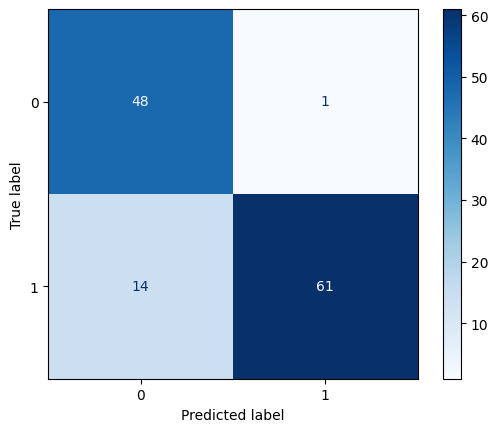

(0.8905109489051095, 0.8425414364640885)

In [ ]:
train_blstm(total_length, text_words_mean, aug_X_train, aug_y_train)